In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np


In [13]:
data = {'AnnualIncome': [
        15, 15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19.5, 
        20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24, 24.5, 
        25, 25.5, 26, 26.5, 27, 27.5, 28, 28.5, 29, 29.5, 
        30, 30.5, 31, 31.5, 32, 32.5, 33, 33.5, 34, 34.5, 
        35,   # Normal points
        80, 85, 90  # Outliers
    ],
    'SpendingScore': [
        39, 42, 45, 48, 51, 54, 57, 60, 63, 66,
        69, 72, 75, 78, 81, 84, 87, 90, 93, 96,
        6, 9, 12, 15, 18, 21, 24, 27, 30, 33,
        5, 8, 11, 14, 17, 20, 23, 26, 29, 32,
        56,   # Normal points
        2, 3, 100  # Outliers
    ]}

df = pd.DataFrame(data)

# Display the first few rows of the dataset
print(df.head())

   AnnualIncome  SpendingScore
0          15.0             39
1          15.5             42
2          16.0             45
3          16.5             48
4          17.0             51


In [14]:
# Normalize the dataset using StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Convert the scaled data back into a DataFrame for easier handling
df_scaled = pd.DataFrame(df_scaled, columns=['AnnualIncome', 'SpendingScore'])
print(df_scaled.head())

   AnnualIncome  SpendingScore
0     -0.869761      -0.135877
1     -0.838899      -0.033387
2     -0.808036       0.069103
3     -0.777174       0.171594
4     -0.746311       0.274084


### Implementing DBSCAN clustering

In [15]:
from sklearn.cluster import DBSCAN

min_samples = 3

# Initialize DBSCAN with the parameters
# eps=0.5: Starting neighborhood radius (empirical initial value)
# min_samples=3: Minimum points to form a cluster (empirical initial value)
dbscan = DBSCAN(eps=0.5, min_samples=min_samples)

# Fit the model to the scaled data
dbscan.fit(df_scaled)

labels = dbscan.labels_

# Assign cluster labels to the data points
df['Cluster'] = labels

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_ratio = np.mean(labels == -1)
print(f"Clusters: {n_clusters}, Noise ratio: {noise_ratio:.1%}")

# Display the first few rows with cluster labels
# print(df.head())

Clusters: 2, Noise ratio: 9.1%


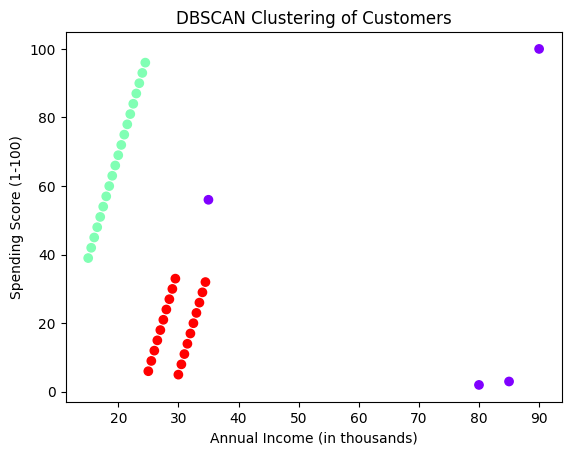

In [9]:
# Plot the clusters
plt.scatter(df['AnnualIncome'], df['SpendingScore'], c=df['Cluster'], cmap='rainbow')
plt.title('DBSCAN Clustering of Customers')
plt.xlabel('Annual Income (in thousands)')
plt.ylabel('Spending Score (1-100)')
plt.show()

### Use k-distance plot to find a more accurate eps value

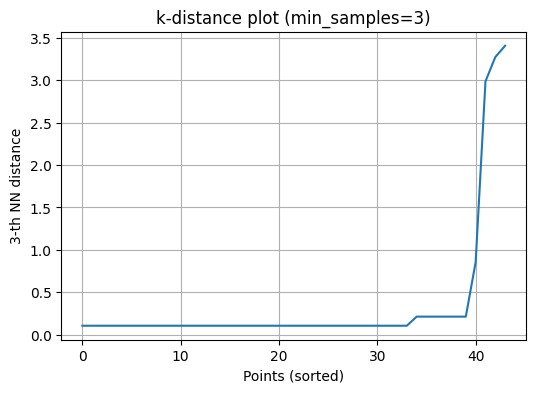

eps=0.30 -> clusters=3, noise_ratio=9.09%
eps=0.50 -> clusters=2, noise_ratio=9.09%
eps=0.70 -> clusters=2, noise_ratio=9.09%
eps=0.90 -> clusters=2, noise_ratio=6.82%


In [18]:
from sklearn.neighbors import NearestNeighbors

# 计算每个点到第 min_samples 个近邻的距离
# 画 k-distance plot，找 eps 肘部
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(df_scaled)
distances, _ = nbrs.kneighbors(df_scaled)
kdist = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(kdist)
plt.title(f'k-distance plot (min_samples={min_samples})')
plt.xlabel('Points (sorted)')
plt.ylabel(f'{min_samples}-th NN distance')
plt.grid(True)
plt.show()

# 3) 试几个 eps（围绕肘部值微调）
for eps in [0.3, 0.5, 0.7, 0.9]:
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(df_scaled)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = np.mean(labels == -1)
    print(f"eps={eps:.2f} -> clusters={n_clusters}, noise_ratio={noise_ratio:.2%}")

### 🧩 Interpreting the DBSCAN Output

The **k-distance plot** starts to rise around **y ≈ 0.3**, which suggests that **`eps ≈ 0.30`** is a reasonable elbow point.

#### Experimental Results

| eps | Clusters | Noise Ratio | Interpretation |
|------|-----------|--------------|----------------|
| **0.30** | 3 | 9.09% | ✅ Produces three clear clusters (consistent with the previous K-Means structure) and maintains a low noise level. |
| **0.50 / 0.70** | 2 | 9.09% | ⚠️ The radius increase causes two clusters to merge into one, making the grouping too coarse, while noise remains unchanged. |
| **0.90** | 2 | 6.82% | ❌ Fewer noise points, but at the cost of over-merging clusters (over-clustering). |

#### 🧠 Summary

- If your goal is to **preserve three distinct clusters** with moderate noise, choose  
  **`eps ≈ 0.30`, `min_samples = 3`**.  
- If you prefer **fewer noise points** and are fine with fewer clusters, you can increase  
  **`eps` to around 0.8–0.9**.


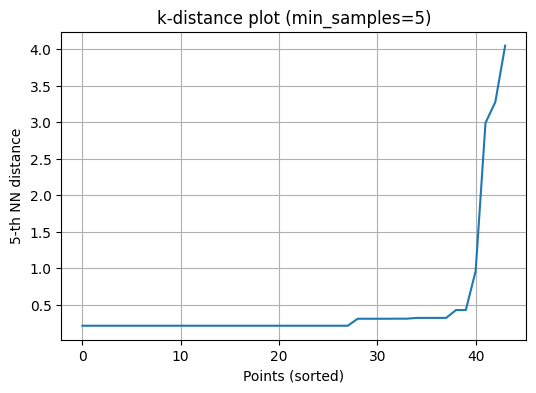

eps=0.30 -> clusters=3, noise_ratio=9.09%
eps=0.50 -> clusters=2, noise_ratio=9.09%
eps=0.70 -> clusters=2, noise_ratio=9.09%
eps=0.90 -> clusters=2, noise_ratio=6.82%


In [19]:
from sklearn.neighbors import NearestNeighbors

min_samples=5

# 计算每个点到第 min_samples 个近邻的距离
# 画 k-distance plot，找 eps 肘部
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(df_scaled)
distances, _ = nbrs.kneighbors(df_scaled)
kdist = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(kdist)
plt.title(f'k-distance plot (min_samples={min_samples})')
plt.xlabel('Points (sorted)')
plt.ylabel(f'{min_samples}-th NN distance')
plt.grid(True)
plt.show()

# 3) 试几个 eps（围绕肘部值微调）
for eps in [0.3, 0.5, 0.7, 0.9]:
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(df_scaled)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = np.mean(labels == -1)
    print(f"eps={eps:.2f} -> clusters={n_clusters}, noise_ratio={noise_ratio:.2%}")

### 🧩 Interpretation of the Adjusted DBSCAN Results

Your adjusted results highlight an important phenomenon — they **confirm the robustness of DBSCAN parameters**.

---

### 🧠 1. Results Overview

| eps | min_samples | clusters | noise_ratio |
|------|--------------|-----------|--------------|
| **0.30** | 5 | 3 | 9.09% |
| **0.50** | 5 | 2 | 9.09% |
| **0.70** | 5 | 2 | 9.09% |
| **0.90** | 5 | 2 | 6.82% |

---

### 🔍 2. Analysis

**Overall stability:**  
Regardless of whether `min_samples = 3` or `5`, `eps = 0.3` consistently yields **3 clusters**,  
indicating that **around 0.3 is a natural boundary** — the elbow point was correctly chosen.

**When `min_samples` increases:**  
- The requirement for a core point becomes stricter (more neighbors needed).  
- However, since your dataset is dense enough, the clustering result remains unchanged.  
✅ This means your clusters are **stable, compact, and well-separated**.

**When `eps` increases (0.5–0.9):**  
- Adjacent clusters start merging into one larger cluster.  
- The noise ratio slightly decreases, but the overall granularity of clustering drops.  
→ This is a typical case of **over-clustering**.

---

### 📈 3. Recommended Parameter Choices

| Goal | Recommended Parameters | Reason |
|------|-------------------------|--------|
| **Preserve fine-grained 3-cluster structure** | `eps = 0.3`, `min_samples = 3–5` | Clear natural boundaries and moderate noise |
| **Reduce noise and merge nearby clusters** | `eps = 0.8`, `min_samples = 5` | Fewer noise points, but merges clusters into larger ones |
| **Build more robust, generalized model** | `eps = 0.35`, `min_samples = 5` | Slightly relaxed radius to avoid boundary misclassification |

---

✅ **In summary:**  
`eps ≈ 0.3` remains the sweet spot — stable clusters, low noise, and consistent with the data’s natural density structure.


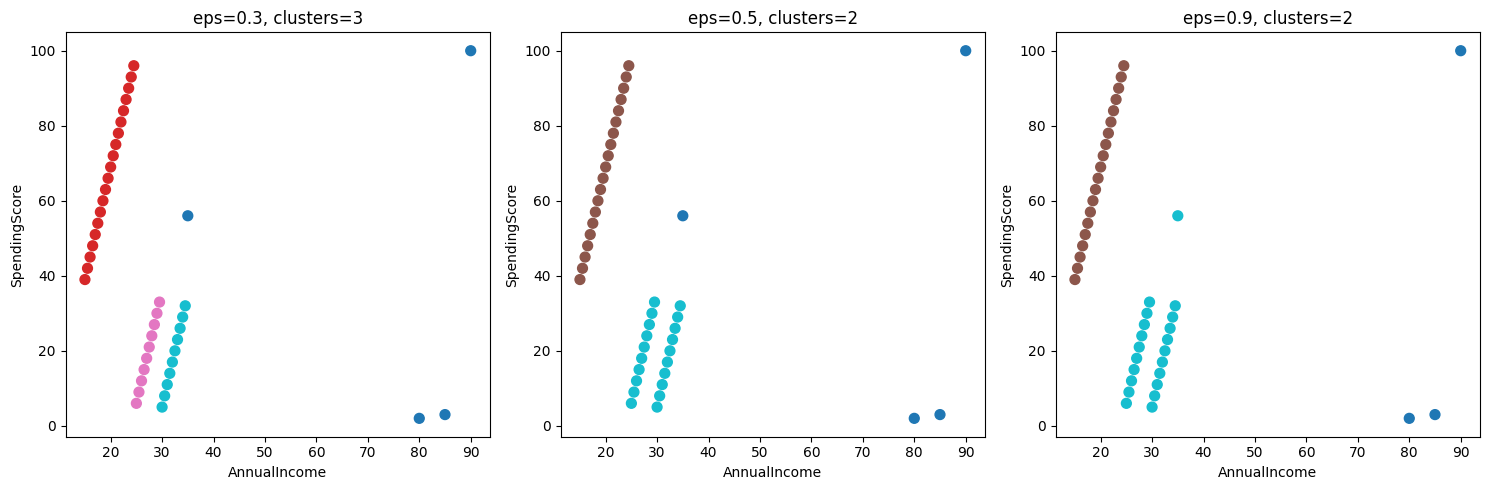

In [20]:
eps_values = [0.3, 0.5, 0.9]

fig, axes = plt.subplots(1, len(eps_values), figsize=(15, 5))

for i, eps in enumerate(eps_values):
    db = DBSCAN(eps=eps, min_samples=5).fit(df_scaled)
    labels = db.labels_
    axes[i].scatter(df['AnnualIncome'], df['SpendingScore'],
                    c=labels, cmap='tab10', s=50)
    axes[i].set_title(f'eps={eps}, clusters={len(set(labels))-(1 if -1 in labels else 0)}')
    axes[i].set_xlabel('AnnualIncome')
    axes[i].set_ylabel('SpendingScore')
plt.tight_layout()
plt.show()

### 🧩 Interpretation of DBSCAN Results

The three subplots demonstrate how changing the **`eps` (epsilon)** parameter affects the clustering behavior in DBSCAN.

| Plot | Parameters | Result | Interpretation |
|------|-------------|---------|----------------|
| **Left (`eps=0.3`)** | Small radius, high density requirement | **3 distinct clusters + clear outliers** | ✅ Ideal setting — DBSCAN successfully identifies three separate dense regions and correctly marks isolated points as noise. |
| **Middle (`eps=0.5`)** | Moderate radius | **2 clusters** | ⚠️ Neighboring lower clusters merge into one because the increased radius allows their neighborhoods to overlap. |
| **Right (`eps=0.9`)** | Large radius | **2 clusters (fewer outliers)** | ❌ Over-clustering — the radius is too large, so even an isolated point becomes part of the lower cluster. |

---

### 🧠 Conceptual Summary

- **Core point** → has at least `min_samples` points within distance `eps`.  
- **Border point** → lies inside a core point’s neighborhood but doesn’t have enough neighbors itself.  
- **Noise point** → doesn’t belong to any cluster.

As **`eps` increases**:
- More points become **core** points.  
- Neighboring clusters **merge together**.  
- **Noise points decrease**, but **cluster boundaries blur**.

---

### ✅ In short:
> - Small `eps` → more clusters, more noise (under-clustering).  
> - Large `eps` → fewer clusters, less noise (over-clustering).  
> - **Best balance here: `eps ≈ 0.3`, `min_samples = 3–5`**, which preserves the natural three-cluster structure clearly.
